# Spatial Patterns of Warming Rates at an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot the spatial patterns of SST values and warm rates at various temporal resolutions for a Australian Marine Park.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 30th, Jan, 2020

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features
import numpy as np

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between July 2002 and July 2019.**

In [3]:
dc.list_products()

,name,description,label,platform,lon,format,time,instrument,product_type,creation_time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,None,MODIS,None,None,None,None,modis_oc_1d,None,None,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


**plot the AMP shapefile**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

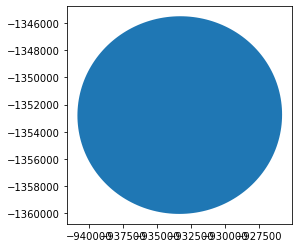

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**load sst data for the AMP**

In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:14:42.079315 to finish


**create a mask for the area covered by the AMP polygon**

In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

In [7]:
data = mask_invalid_data(data)

In [8]:
# note the time dimension: 6214
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

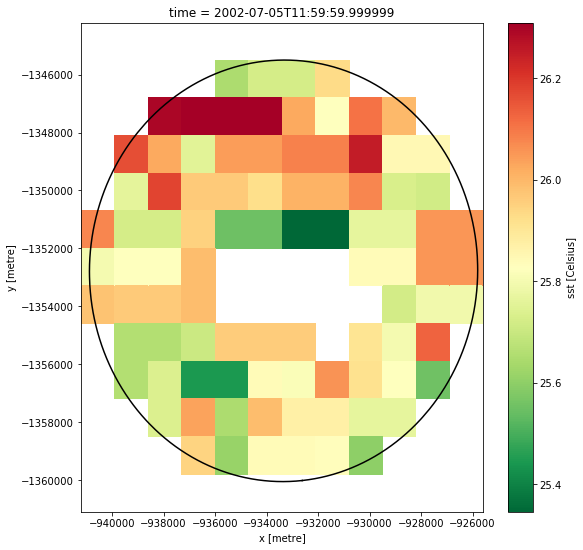

In [9]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

**the pad function for linear interpolation of missing data in a time series**

In [10]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


##### **sstDF contains all SST data loaded: 156 (12 x 13) locations (as columns) with 6214 daily time-series (as rows)**

In [11]:
sstDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.y.size:
    while lonIndex < data.x.size:
        lat = data.sst[:,latIndex,lonIndex].y.values
        lon = data.sst[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(str(id))
        sstData = data.sst[:,latIndex,lonIndex].values
        sstDF[str(id)] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
sstDF['date'] = dateList
sstDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

**add year column**

In [12]:
yearList = []
for date in sstDF.index:
    year = date[:4]
    yearList.append(year)
sstDF['year'] = yearList

In [14]:
sstDF.tail(10)

,1,2,3,4,5,6,7,8,9,10,...,148,149,150,151,152,153,154,155,156,year
date,,,,,,,,,,,,,,,,,,,,,
20190713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
20190721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019


**The yearSSTDF contains time-series annual mean SST values for pixels that have at least some valid data**

In [13]:
yearSSTDF = pd.DataFrame()
for col in sstDF.columns:
    print(col)
    if col == 'year':
        break
    else:
        nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if nuData > 0:            
            x = sstDF[col].groupby(sstDF['year']) # groupby year
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            yearSSTDF[col] = xDF['mean'] # only interest in the mean statistic
#yearSSTDF['year'] = xDF.index
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
year


In [16]:
yearSSTDF

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
year,,,,,,,,,,,,,,,,,,,,,
2002,27.571341,27.486544,27.428913,27.553631,27.547571,27.553806,27.505072,27.462170,27.529646,27.573595,...,27.649313,27.679312,27.623932,27.681076,27.682392,27.754181,27.721832,27.738661,27.665751,27.766249
2003,28.471537,28.429493,28.407637,28.376453,28.473763,28.483059,28.435814,28.426439,28.453888,28.422243,...,28.549700,28.542662,28.579657,28.604761,28.483374,28.517136,28.556870,28.606476,28.607676,28.617659
2004,28.355881,28.371675,28.385805,28.326866,28.328224,28.309189,28.431479,28.430292,28.290585,28.305372,...,28.323532,28.422045,28.470188,28.461853,28.463799,28.492447,28.440741,28.387627,28.416851,28.465513
2005,28.608070,28.628437,28.690229,28.678137,28.721485,28.710398,28.647797,28.674213,28.651178,28.713070,...,28.658710,28.675592,28.680399,28.705236,28.726305,28.729452,28.722858,28.631779,28.673254,28.759960
2006,27.600086,27.689226,27.663925,27.607376,27.775705,27.717197,27.711460,27.675879,27.643917,27.615961,...,27.558754,27.481133,27.544922,27.524286,27.580267,27.609482,27.693266,27.591932,27.597025,27.608719
2007,28.069437,28.029488,28.071896,28.109100,28.077097,28.072939,28.055042,28.089521,28.119432,28.103958,...,27.993401,27.999617,27.980263,27.925489,28.053204,28.068966,28.061783,27.992271,28.023746,27.973715
2008,28.105392,28.102970,28.137606,28.152706,28.151928,28.119858,28.067713,28.117954,28.097466,28.128412,...,28.169218,28.198969,28.191620,28.205269,28.214136,28.210417,28.168806,28.149796,28.171179,28.220184
2009,28.837255,28.841068,28.910990,28.828228,28.888353,28.897745,28.916601,28.843596,28.826910,28.837545,...,28.973513,28.938093,28.843292,28.814066,28.950123,28.981962,28.938368,28.962881,28.924429,28.928110
2010,28.927000,28.939358,28.984997,28.959253,28.967615,28.925978,28.894079,28.883812,28.914293,28.938648,...,28.944172,28.871468,28.875805,28.861361,29.083588,28.972799,29.063139,28.980051,28.970436,28.899746


**years 2002 and 2019 are partial years and thus should be excluded**

In [14]:
yearSSTDF1 = yearSSTDF.loc['2003':'2018']

In [18]:
yearSSTDF1

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
year,,,,,,,,,,,,,,,,,,,,,
2003,28.471537,28.429493,28.407637,28.376453,28.473763,28.483059,28.435814,28.426439,28.453888,28.422243,...,28.549700,28.542662,28.579657,28.604761,28.483374,28.517136,28.556870,28.606476,28.607676,28.617659
2004,28.355881,28.371675,28.385805,28.326866,28.328224,28.309189,28.431479,28.430292,28.290585,28.305372,...,28.323532,28.422045,28.470188,28.461853,28.463799,28.492447,28.440741,28.387627,28.416851,28.465513
2005,28.608070,28.628437,28.690229,28.678137,28.721485,28.710398,28.647797,28.674213,28.651178,28.713070,...,28.658710,28.675592,28.680399,28.705236,28.726305,28.729452,28.722858,28.631779,28.673254,28.759960
2006,27.600086,27.689226,27.663925,27.607376,27.775705,27.717197,27.711460,27.675879,27.643917,27.615961,...,27.558754,27.481133,27.544922,27.524286,27.580267,27.609482,27.693266,27.591932,27.597025,27.608719
2007,28.069437,28.029488,28.071896,28.109100,28.077097,28.072939,28.055042,28.089521,28.119432,28.103958,...,27.993401,27.999617,27.980263,27.925489,28.053204,28.068966,28.061783,27.992271,28.023746,27.973715
2008,28.105392,28.102970,28.137606,28.152706,28.151928,28.119858,28.067713,28.117954,28.097466,28.128412,...,28.169218,28.198969,28.191620,28.205269,28.214136,28.210417,28.168806,28.149796,28.171179,28.220184
2009,28.837255,28.841068,28.910990,28.828228,28.888353,28.897745,28.916601,28.843596,28.826910,28.837545,...,28.973513,28.938093,28.843292,28.814066,28.950123,28.981962,28.938368,28.962881,28.924429,28.928110
2010,28.927000,28.939358,28.984997,28.959253,28.967615,28.925978,28.894079,28.883812,28.914293,28.938648,...,28.944172,28.871468,28.875805,28.861361,29.083588,28.972799,29.063139,28.980051,28.970436,28.899746
2011,27.284382,27.294802,27.295725,27.211107,27.227455,27.298302,27.301096,27.246708,27.228941,27.210323,...,27.182526,27.041069,27.058435,27.087309,27.063099,27.178406,27.150185,27.087814,27.011669,27.055235


**The yearRateDF contains, for each valid pixel, the fitted warming rate, the number of days with data and the observation frequency within the time-series of the annual mean. A low observation frequency indicates high uncertainty of the fitted warming rate.**

In [15]:
import statsmodels.formula.api as sm
ind = np.arange(1,yearSSTDF1.index.size+1,1)
yearSSTDF1['ind'] = ind
yearRateDF = pd.DataFrame()
idList = []
rateList = []
pValueList = []
for col in yearSSTDF1.columns:
    print(col)
    if col.isdigit():
        idList.append(col)
        # note the Q() function for the proper handling of the number as a column name
        formula = 'Q("' + col + '")' + ' ~ ind'
        
        fit = sm.ols(formula=formula, data=yearSSTDF1).fit()

        predict = fit.predict(yearSSTDF1)
        yearSSTDF1['fitted'] = predict
        rate = round(fit.params[1],3)
        pValue = round(fit.pvalues[1],2)
        
        rateList.append(rate)
        pValueList.append(pValue)
yearRateDF['id'] = idList
yearRateDF['rate'] = rateList
yearRateDF['pValue'] = pValueList

countList = []
freqList = []
for col in sstDF.columns:
    if col.isdigit():        
        x = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if x > 0:            
            f = x/sstDF.index.size
            countList.append(x)
            freqList.append(f)
yearRateDF['count'] = countList
yearRateDF['frequency'] = freqList
yearRateDF.set_index("id",inplace=True)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


17
18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
ind


**add the x and y columns to the yearRateDF**

In [16]:
xList = []
yList = []
for id in yearRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearRateDF['x'] = xList
yearRateDF['y'] = yList

In [17]:
yearRateDF

,rate,pValue,count,frequency,x,y
id,,,,,,
17,0.050,0.14,2165,0.348407,-935350,-1346150
18,0.048,0.15,2171,0.349372,-934050,-1346150
19,0.047,0.16,2172,0.349533,-932750,-1346150
20,0.047,0.16,2186,0.351786,-931450,-1346150
27,0.044,0.19,2152,0.346315,-937950,-1347450
...,...,...,...,...,...,...
137,0.043,0.20,2162,0.347924,-935350,-1359150
138,0.041,0.22,2148,0.345671,-934050,-1359150
139,0.046,0.18,2154,0.346637,-932750,-1359150


**plot the warming rates for the pixels;the low observation frequency could indicate high uncertainty**

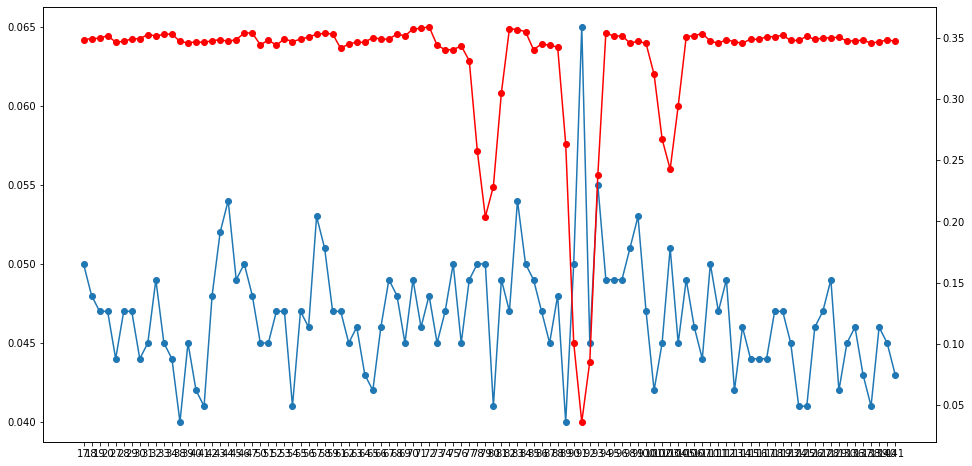

In [18]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(yearRateDF.index,yearRateDF['rate'],marker='o')
ax2.plot(yearRateDF.index,yearRateDF['frequency'],color='red',marker='o')

**convert the yearRateDF to an xarray dataset**

In [19]:
import xarray as xr
yearRateDF1 = yearRateDF.copy()
yearRateDF1.set_index(['y','x'],inplace=True)
yearRateData = xr.Dataset.from_dataframe(yearRateDF1)
yearRateData.attrs['crs']='EPSG:3577'

**display the spatial distribution of the warming rates; the black dots indicate that the pixels have statitically significant warming rates at 85% confidence level**

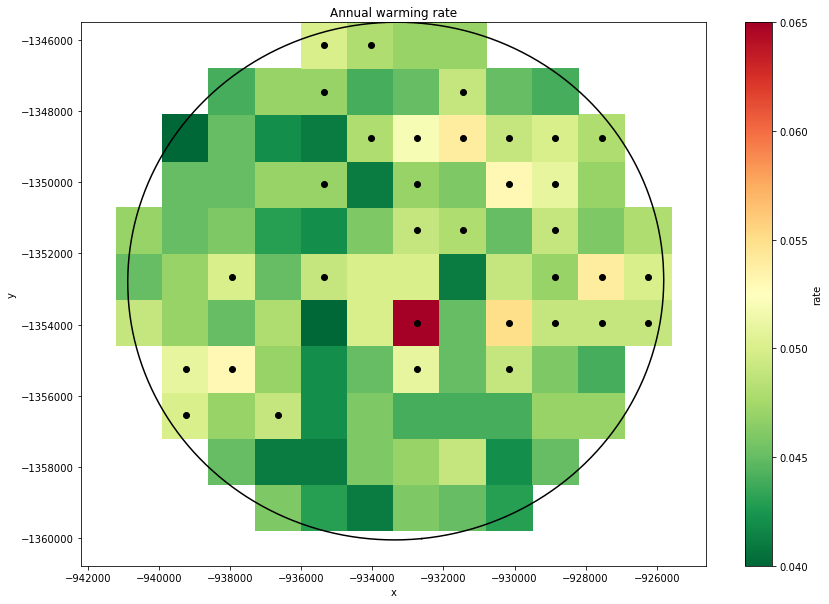

In [20]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

plt.figure(figsize=(14,10))

yearRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Annual warming rate')
plt.axis('equal')
# only highlight data points where pValue <= 0.15, representing significance level >= 85%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.15]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


**export the xarray dataset to a netcdf file**

In [41]:
yearRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearRateData.nc')

**plot the data, save it as an image, display the image**

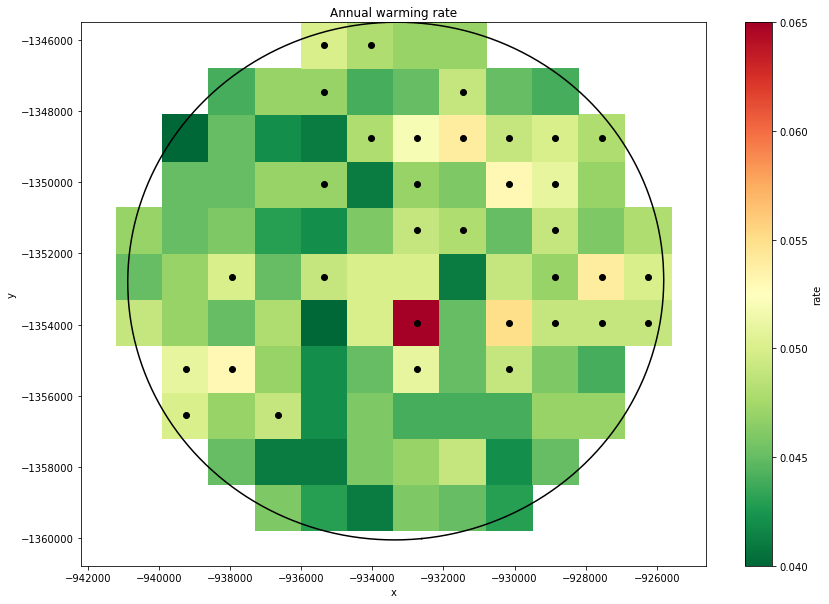

In [21]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

plt.figure(figsize=(14,10))

yearRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Annual warming rate')
plt.axis('equal')
# only highlight data points where pValue <= 0.15, representing significance level >= 85%
tempDF = yearRateDF[yearRateDF['pValue'] <= 0.15]
x = tempDF['x']
y = tempDF['y']

plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

figName = "rateTest.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**The overallDF contains the long-term mean (std) SST values for each valid pixels**

In [22]:
overallDF = pd.DataFrame()
meanList = []
stdList = []
countList = []
freqList = []
idList = []
for col in sstDF.columns:
    if col.isdigit():        
        x = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if x > 0:        
            sstMean = sstDF[col].mean()
            sstStd = sstDF[col].std()
            f = x/sstDF.index.size
            meanList.append(sstMean)
            stdList.append(sstStd)
            countList.append(x)
            freqList.append(f)
            idList.append(col)
overallDF['id'] = idList
overallDF['mean'] = meanList
overallDF['std'] = stdList
overallDF['count'] = countList
overallDF['frequency'] = freqList
overallDF.set_index('id', inplace=True)

xList = []
yList = []
for id in overallDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
overallDF['x'] = xList
overallDF['y'] = yList

In [48]:
overallDF

,mean,std,count,frequency,x,y
id,,,,,,
17,28.465200,1.709625,2165,0.348407,-935350,-1346150
18,28.456987,1.710461,2171,0.349372,-934050,-1346150
19,28.467133,1.696662,2172,0.349533,-932750,-1346150
20,28.450039,1.696973,2186,0.351786,-931450,-1346150
27,28.477938,1.728678,2152,0.346315,-937950,-1347450
...,...,...,...,...,...,...
137,28.504910,1.751125,2162,0.347924,-935350,-1359150
138,28.494637,1.727640,2148,0.345671,-934050,-1359150
139,28.485571,1.722352,2154,0.346637,-932750,-1359150


**convert the dataframe to an xarray daaset**

In [23]:
import xarray as xr
overallDF1 = overallDF.copy()
overallDF1.set_index(['y','x'],inplace=True)
overallData = xr.Dataset.from_dataframe(overallDF1)
overallData.attrs['crs']='EPSG:3577'

In [28]:
overallData

<xarray.Dataset>
Dimensions:    (x: 12, y: 11)
Coordinates:
  * y          (y) int64 -1359150 -1357850 -1356550 ... -1347450 -1346150
  * x          (x) int64 -940550 -939250 -937950 ... -928850 -927550 -926250
Data variables:
    mean       (y, x) float64 nan nan nan 28.5 28.5 ... 28.45 nan nan nan nan
    std        (y, x) float64 nan nan nan 1.756 1.751 ... 1.697 nan nan nan nan
    count      (y, x) float64 nan nan nan 2.16e+03 2.162e+03 ... nan nan nan nan
    frequency  (y, x) float64 nan nan nan 0.3476 0.3479 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

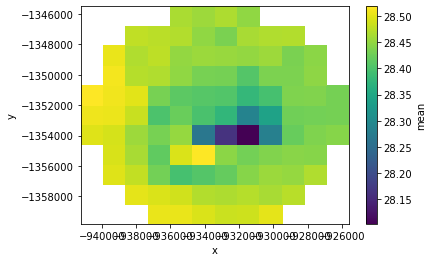

In [51]:
overallData['mean'].plot()

In [52]:
overallData.to_netcdf(path='/home/547/zxh547/dea-notebooks/overallData.nc')

**plot the spatial distribution of the SST long-term mean; the black dots indicate that the pixels have observation frequency > 30% of the time-series**

In [24]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(10,10))
overallData['mean'].plot(cmap='RdYlGn_r')
for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
plt.title('SST long-term mean')
# only highlight data points where frequency > 30%
tempDF = overallDF[overallDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
figName = "overallMeanTest.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**add season and month columns**

In [25]:
seasonList = []
monthList = []
for date in sstDF.index:
    month = date[4:6]
    monthList.append(month)
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    seasonList.append(season)
sstDF['season'] = seasonList
sstDF['month'] = monthList

In [65]:
sstDF['20100902':'20101203']

,1,2,3,4,5,6,7,8,9,10,...,150,151,152,153,154,155,156,year,season,month
date,,,,,,,,,,,,,,,,,,,,,
20100902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,09
20100903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,09
20100904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,09
20100905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,09
20100906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,11
20101130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,spring,11
20101201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,summer,12


**seasonal statistics (e.g., mean, std, etc) for each pixel**

In [26]:
winterSSTDF = pd.DataFrame()
springSSTDF = pd.DataFrame()
summerSSTDF = pd.DataFrame()
autumnSSTDF = pd.DataFrame()
wi_meanList = []
wi_stdList = []
wi_countList = []
wi_freqList = []
sp_meanList = []
sp_stdList = []
sp_countList = []
sp_freqList = []
su_meanList = []
su_stdList = []
su_countList = []
su_freqList = []
au_meanList = []
au_stdList = []
au_countList = []
au_freqList = []

idList = []
for col in sstDF.columns:
    print(col)
    if col.isdigit():
             
        nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
        if nuData > 0:            
            x = sstDF[col].groupby(sstDF['season']) # groupby season
            xDF = x.describe() # a DataFrame containing the results of the groupby operation
            wi_mean = xDF.loc['winter']['mean']
            wi_std = xDF.loc['winter']['std']
            wi_count = xDF.loc['winter']['count']
            wi_freq = xDF.loc['winter']['count'] / (sstDF['season']=='winter').sum()
            
            sp_mean = xDF.loc['spring']['mean']
            sp_std = xDF.loc['spring']['std']
            sp_count = xDF.loc['spring']['count']
            sp_freq = xDF.loc['spring']['count'] / (sstDF['season']=='spring').sum()
            
            su_mean = xDF.loc['summer']['mean']
            su_std = xDF.loc['summer']['std']
            su_count = xDF.loc['summer']['count']
            su_freq = xDF.loc['summer']['count'] / (sstDF['season']=='summer').sum()
            
            au_mean = xDF.loc['autumn']['mean']
            au_std = xDF.loc['autumn']['std']
            au_count = xDF.loc['autumn']['count']
            au_freq = xDF.loc['autumn']['count'] / (sstDF['season']=='autumn').sum()
            
            idList.append(col)
            
            wi_meanList.append(wi_mean)
            wi_stdList.append(wi_std)
            wi_countList.append(wi_count)
            wi_freqList.append(wi_freq)
            
            sp_meanList.append(sp_mean)
            sp_stdList.append(sp_std)
            sp_countList.append(sp_count)
            sp_freqList.append(sp_freq)
            
            su_meanList.append(su_mean)
            su_stdList.append(su_std)
            su_countList.append(su_count)
            su_freqList.append(su_freq)
            
            au_meanList.append(au_mean)
            au_stdList.append(au_std)
            au_countList.append(au_count)
            au_freqList.append(au_freq)
            
winterSSTDF['id'] = idList
winterSSTDF['mean'] = wi_meanList
winterSSTDF['std'] = wi_stdList
winterSSTDF['count'] = wi_countList
winterSSTDF['frequency'] = wi_freqList
winterSSTDF.set_index('id',inplace=True)

springSSTDF['id'] = idList
springSSTDF['mean'] = sp_meanList
springSSTDF['std'] = sp_stdList
springSSTDF['count'] = sp_countList
springSSTDF['frequency'] = sp_freqList
springSSTDF.set_index('id',inplace=True)

summerSSTDF['id'] = idList
summerSSTDF['mean'] = su_meanList
summerSSTDF['std'] = su_stdList
summerSSTDF['count'] = su_countList
summerSSTDF['frequency'] = su_freqList
summerSSTDF.set_index('id',inplace=True)

autumnSSTDF['id'] = idList
autumnSSTDF['mean'] = au_meanList
autumnSSTDF['std'] = au_stdList
autumnSSTDF['count'] = au_countList
autumnSSTDF['frequency'] = au_freqList
autumnSSTDF.set_index('id',inplace=True)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
year
season
month


**add x and y to the seasonal dataframes**

In [27]:
xList = []
yList = []
for id in winterSSTDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
winterSSTDF['x'] = xList
winterSSTDF['y'] = yList

springSSTDF['x'] = xList
springSSTDF['y'] = yList

summerSSTDF['x'] = xList
summerSSTDF['y'] = yList

autumnSSTDF['x'] = xList
autumnSSTDF['y'] = yList

In [40]:
autumnSSTDF1

mean       std  count  frequency
y        x                                             
-1346150 -935350  29.563869  1.217620  575.0   0.367647
         -934050  29.550768  1.215024  584.0   0.373402
         -932750  29.539955  1.218791  597.0   0.381714
         -931450  29.529594  1.196809  578.0   0.369565
-1347450 -937950  29.573530  1.236226  581.0   0.371483
...                     ...       ...    ...        ...
-1359150 -935350  29.660278  1.193065  580.0   0.370844
         -934050  29.624638  1.179777  582.0   0.372123
         -932750  29.625038  1.166257  576.0   0.368286
         -931450  29.596806  1.179184  579.0   0.370205
         -930150  29.585140  1.221353  564.0   0.360614

[102 rows x 4 columns]

**convert dataframes to xarry datasets and export them as netcdf files**

In [28]:
import xarray as xr
winterSSTDF1 = winterSSTDF.copy()
winterSSTDF1.set_index(['y','x'],inplace=True)
winterSSTData = xr.Dataset.from_dataframe(winterSSTDF1)
winterSSTData.attrs['crs']='EPSG:3577'
winterSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/winterSSTData.nc')

springSSTDF1 = springSSTDF.copy()
springSSTDF1.set_index(['y','x'],inplace=True)
springSSTData = xr.Dataset.from_dataframe(springSSTDF1)
springSSTData.attrs['crs']='EPSG:3577'
springSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/springSSTData.nc')

summerSSTDF1 = summerSSTDF.copy()
summerSSTDF1.set_index(['y','x'],inplace=True)
summerSSTData = xr.Dataset.from_dataframe(summerSSTDF1)
summerSSTData.attrs['crs']='EPSG:3577'
summerSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/summerSSTData.nc')

autumnSSTDF1 =autumnSSTDF.copy()
autumnSSTDF1.set_index(['y','x'],inplace=True)
autumnSSTData = xr.Dataset.from_dataframe(autumnSSTDF1)
autumnSSTData.attrs['crs']='EPSG:3577'
autumnSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/autumnSSTData.nc')

In [29]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(10,10))

for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
winterSSTData['mean'].plot(cmap='RdYlGn_r')
figName = "winterMeanTest.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**display spatial distributions of seasonal mean; the black dots indicate the observation frequency greater than 30%**

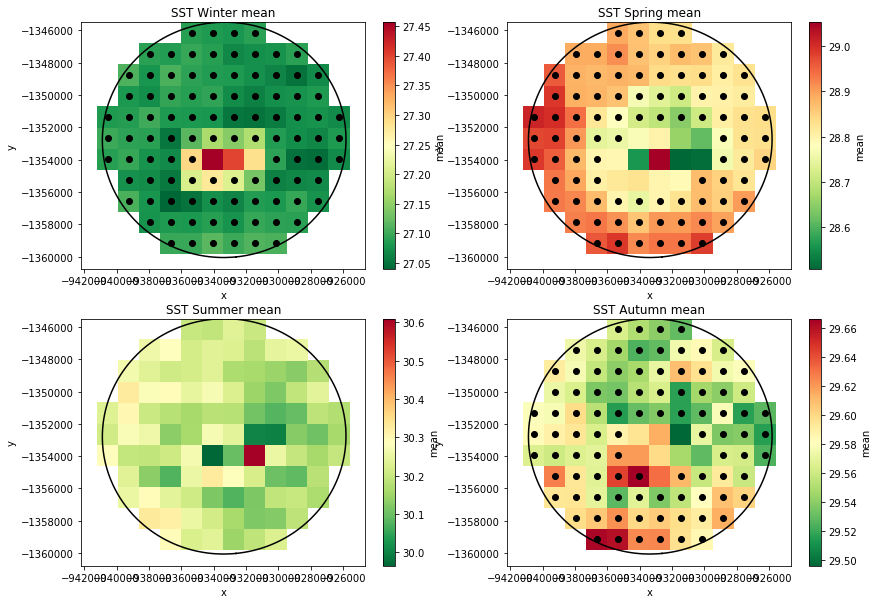

In [30]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
winterSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST Winter mean')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = winterSSTDF[winterSSTDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,2)
springSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST Spring mean')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = springSSTDF[springSSTDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,3)
summerSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST Summer mean')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = summerSSTDF[summerSSTDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,4)
autumnSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST Autumn mean')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = autumnSSTDF[autumnSSTDF['frequency'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

**A conveinent function for calculating SST monthly statistics**

In [31]:
def monthDF(month):
    meanList = []
    stdList = []
    countList = []
    freqList = []
    idList = []
    tempDF = pd.DataFrame()
    for col in sstDF.columns:
        if col.isdigit():
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            if nuData > 0:            
                x = sstDF[col].groupby(sstDF['month']) # groupby season
                xDF = x.describe() # a DataFrame containing the results of the groupby operation
                mean = xDF.loc[month]['mean']
                std = xDF.loc[month]['std']
                count = xDF.loc[month]['count']
                freq = xDF.loc[month]['count'] / (sstDF['month']==month).sum() 

                idList.append(col)

                meanList.append(mean)
                stdList.append(std)
                countList.append(count)
                freqList.append(freq)
    tempDF['id'] = idList
    tempDF['mean'] = meanList
    tempDF['std'] = stdList
    tempDF['count'] = countList
    tempDF['freq'] = freqList
    tempDF.set_index('id',inplace=True)
    return tempDF


    

**calculate monthly statistics for each valid pixel**

In [32]:
JanSSTDF = monthDF('01')
FebSSTDF = monthDF('02')
MarSSTDF = monthDF('03')
AprSSTDF = monthDF('04')
MaySSTDF = monthDF('05')
JunSSTDF = monthDF('06')
JulSSTDF = monthDF('07')
AugSSTDF = monthDF('08')
SepSSTDF = monthDF('09')
OctSSTDF = monthDF('10')
NovSSTDF = monthDF('11')
DecSSTDF = monthDF('12')
             

        

In [82]:
JanSSTDF

,mean,std,count,freq
id,,,,
17,29.648977,1.281813,54.0,0.102467
18,29.595772,1.436439,52.0,0.098672
19,29.814577,1.166869,47.0,0.089184
20,29.605799,1.188583,50.0,0.094877
27,29.826763,1.171637,51.0,0.096774
...,...,...,...,...
137,29.773575,1.193766,56.0,0.106262
138,29.810471,1.234304,53.0,0.100569
139,29.666086,1.272866,55.0,0.104364


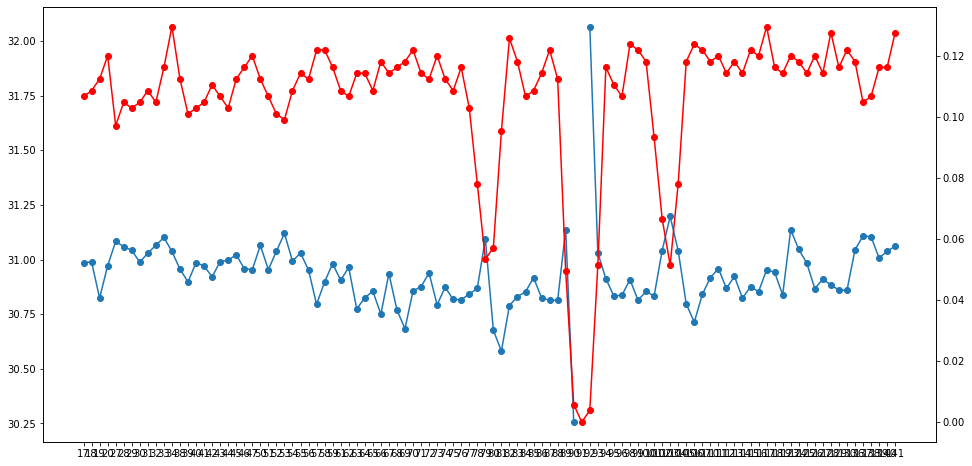

In [33]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.plot(DecSSTDF.index,DecSSTDF['mean'],marker='o')
ax2.plot(DecSSTDF.index,DecSSTDF['freq'],color='red',marker='o')

In [34]:
xList = []
yList = []
for id in JanSSTDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
JanSSTDF['x'] = xList
JanSSTDF['y'] = yList
FebSSTDF['x'] = xList
FebSSTDF['y'] = yList
MarSSTDF['x'] = xList
MarSSTDF['y'] = yList
AprSSTDF['x'] = xList
AprSSTDF['y'] = yList
MaySSTDF['x'] = xList
MaySSTDF['y'] = yList
JunSSTDF['x'] = xList
JunSSTDF['y'] = yList
JulSSTDF['x'] = xList
JulSSTDF['y'] = yList
AugSSTDF['x'] = xList
AugSSTDF['y'] = yList
SepSSTDF['x'] = xList
SepSSTDF['y'] = yList
OctSSTDF['x'] = xList
OctSSTDF['y'] = yList
NovSSTDF['x'] = xList
NovSSTDF['y'] = yList
DecSSTDF['x'] = xList
DecSSTDF['y'] = yList



In [84]:
JanSSTDF

,mean,std,count,freq,x,y
id,,,,,,
17,29.648977,1.281813,54.0,0.102467,-935350,-1346150
18,29.595772,1.436439,52.0,0.098672,-934050,-1346150
19,29.814577,1.166869,47.0,0.089184,-932750,-1346150
20,29.605799,1.188583,50.0,0.094877,-931450,-1346150
27,29.826763,1.171637,51.0,0.096774,-937950,-1347450
...,...,...,...,...,...,...
137,29.773575,1.193766,56.0,0.106262,-935350,-1359150
138,29.810471,1.234304,53.0,0.100569,-934050,-1359150
139,29.666086,1.272866,55.0,0.104364,-932750,-1359150


In [108]:
AugSSTDF

,mean,std,count,freq,x,y
id,,,,,,
17,26.747530,0.823777,308.0,0.592308,-935350,-1346150
18,26.741005,0.836695,308.0,0.592308,-934050,-1346150
19,26.765541,0.797264,298.0,0.573077,-932750,-1346150
20,26.776363,0.854612,310.0,0.596154,-931450,-1346150
27,26.757278,0.884697,306.0,0.588462,-937950,-1347450
...,...,...,...,...,...,...
137,26.781273,0.873815,309.0,0.594231,-935350,-1359150
138,26.796328,0.868002,310.0,0.596154,-934050,-1359150
139,26.781073,0.857511,309.0,0.594231,-932750,-1359150


In [35]:
import xarray as xr
JanSSTDF1 = JanSSTDF.copy()
JanSSTDF1.set_index(['y','x'],inplace=True)
JanSSTData = xr.Dataset.from_dataframe(JanSSTDF1)
JanSSTData.attrs['crs']='EPSG:3577'
JanSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JanSSTData.nc')

import xarray as xr
FebSSTDF1 = FebSSTDF.copy()
FebSSTDF1.set_index(['y','x'],inplace=True)
FebSSTData = xr.Dataset.from_dataframe(FebSSTDF1)
FebSSTData.attrs['crs']='EPSG:3577'
FebSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/FebSSTData.nc')

import xarray as xr
MarSSTDF1 = MarSSTDF.copy()
MarSSTDF1.set_index(['y','x'],inplace=True)
MarSSTData = xr.Dataset.from_dataframe(MarSSTDF1)
MarSSTData.attrs['crs']='EPSG:3577'
MarSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/MarSSTData.nc')

import xarray as xr
AprSSTDF1 = AprSSTDF.copy()
AprSSTDF1.set_index(['y','x'],inplace=True)
AprSSTData = xr.Dataset.from_dataframe(AprSSTDF1)
AprSSTData.attrs['crs']='EPSG:3577'
AprSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/AprSSTData.nc')

import xarray as xr
MaySSTDF1 = MaySSTDF.copy()
MaySSTDF1.set_index(['y','x'],inplace=True)
MaySSTData = xr.Dataset.from_dataframe(MaySSTDF1)
MaySSTData.attrs['crs']='EPSG:3577'
MaySSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/MaySSTData.nc')

import xarray as xr
JunSSTDF1 = JunSSTDF.copy()
JunSSTDF1.set_index(['y','x'],inplace=True)
JunSSTData = xr.Dataset.from_dataframe(JunSSTDF1)
JunSSTData.attrs['crs']='EPSG:3577'
JunSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JunSSTData.nc')

import xarray as xr
JulSSTDF1 = JulSSTDF.copy()
JulSSTDF1.set_index(['y','x'],inplace=True)
JulSSTData = xr.Dataset.from_dataframe(JulSSTDF1)
JulSSTData.attrs['crs']='EPSG:3577'
JulSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/JulSSTData.nc')

import xarray as xr
AugSSTDF1 = AugSSTDF.copy()
AugSSTDF1.set_index(['y','x'],inplace=True)
AugSSTData = xr.Dataset.from_dataframe(AugSSTDF1)
AugSSTData.attrs['crs']='EPSG:3577'
AugSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/AugSSTData.nc')

import xarray as xr
SepSSTDF1 = SepSSTDF.copy()
SepSSTDF1.set_index(['y','x'],inplace=True)
SepSSTData = xr.Dataset.from_dataframe(SepSSTDF1)
SepSSTData.attrs['crs']='EPSG:3577'
SepSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/SepSSTData.nc')

import xarray as xr
OctSSTDF1 = OctSSTDF.copy()
OctSSTDF1.set_index(['y','x'],inplace=True)
OctSSTData = xr.Dataset.from_dataframe(OctSSTDF1)
OctSSTData.attrs['crs']='EPSG:3577'
OctSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/OctSSTData.nc')

import xarray as xr
NovSSTDF1 = NovSSTDF.copy()
NovSSTDF1.set_index(['y','x'],inplace=True)
NovSSTData = xr.Dataset.from_dataframe(NovSSTDF1)
NovSSTData.attrs['crs']='EPSG:3577'
NovSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/NovSSTData.nc')

import xarray as xr
DecSSTDF1 = DecSSTDF.copy()
DecSSTDF1.set_index(['y','x'],inplace=True)
DecSSTData = xr.Dataset.from_dataframe(DecSSTDF1)
DecSSTData.attrs['crs']='EPSG:3577'
DecSSTData.to_netcdf(path='/home/547/zxh547/dea-notebooks/DecSSTData.nc')

In [36]:
from PIL import Image
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(10,10))

for shape in LH.shapeRecords():

    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
AugSSTData['mean'].plot(cmap='RdYlGn_r')
figName = "AugMeanTest.png"
plt.savefig("/home/547/zxh547/dea-notebooks/" + figName)
plt.close(fig)
img1 = Image.open("/home/547/zxh547/dea-notebooks/" + figName)
img1.show()

**display spatial distributions of SST monthly mean; the black dots indicate observation frequency greater than 30%**

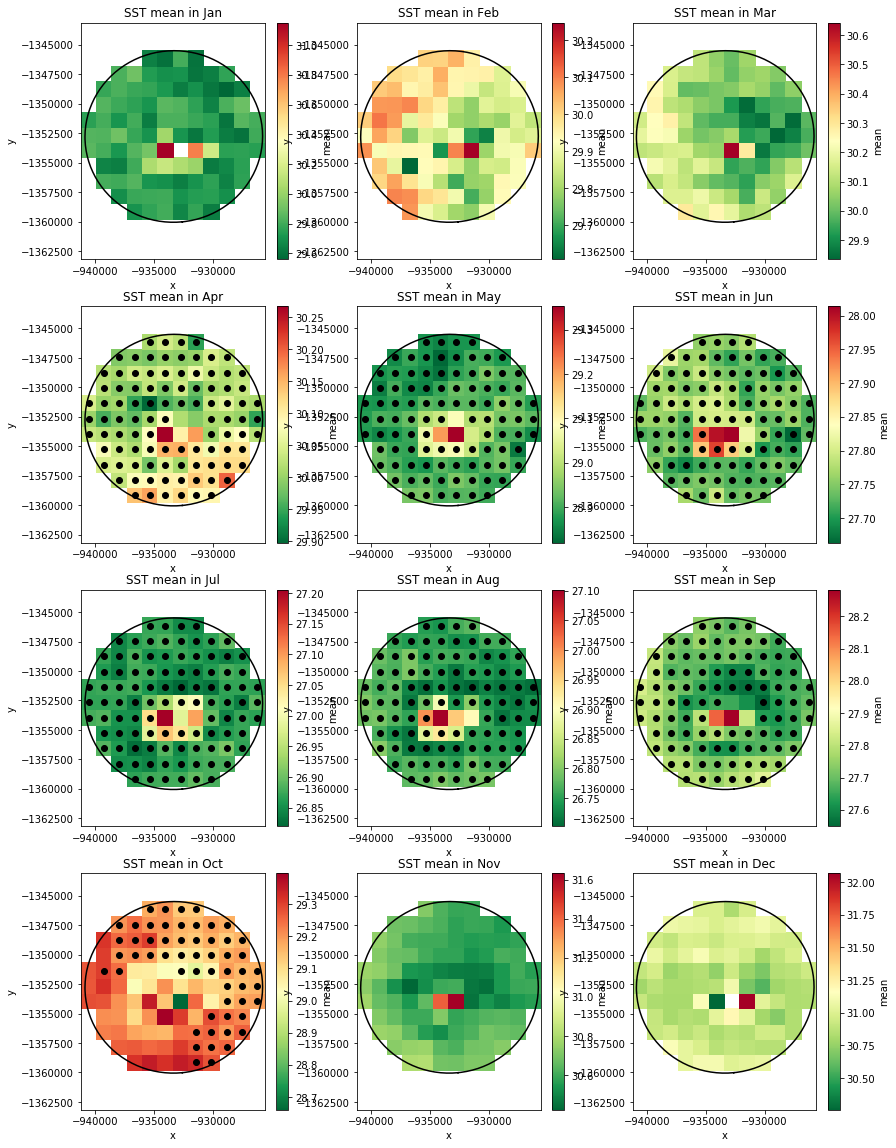

In [37]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(4,3,1)
JanSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Jan')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = JanSSTDF[JanSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,3,2)
FebSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Feb')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = FebSSTDF[FebSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,3)
MarSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Mar')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = MarSSTDF[MarSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,3,4)
AprSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Apr')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = AprSSTDF[AprSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(4,3,5)
MaySSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in May')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = MaySSTDF[MaySSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,6)
JunSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Jun')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = JunSSTDF[JunSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,7)
JulSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Jul')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = JulSSTDF[JulSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,8)
AugSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Aug')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = AugSSTDF[AugSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,9)
SepSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Sep')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = SepSSTDF[SepSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,10)
OctSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Oct')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = OctSSTDF[OctSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,11)
NovSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Nov')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = NovSSTDF[NovSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(4,3,12)
DecSSTData['mean'].plot(cmap='RdYlGn_r')
plt.title('SST mean in Dec')
plt.axis('equal')
# only highlight data points where frequency > 30%
tempDF = DecSSTDF[DecSSTDF['freq'] > 0.3]
x = tempDF['x']
y = tempDF['y']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    


**function for generating annual time-series of seasonal mean for each valid pixel**

In [38]:
def yearseasonSST(season):
    tempDF = pd.DataFrame()
    for col in sstDF.columns:
        
        if col.isdigit():
            
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            if nuData > 0:
                x = sstDF[sstDF['season'] == season]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

In [39]:
yearwinterDF = yearseasonSST('winter')
yearspringDF = yearseasonSST('spring')
yearsummerDF = yearseasonSST('summer')
yearautumnDF = yearseasonSST('autumn')

In [40]:
# years 2002 and 2019 do not contain a full summer season
# summer months 12, 1 and 2 expand two years, this is another issue
yearsummerDF1 = yearsummerDF.loc['2003':'2018']

**function for calculating warming rates of annual time-series of seasonal mean for each valid pixel**

In [41]:
import statsmodels.formula.api as sm
def yearseasonTrend(yearseasonDF,season):
    ind = np.arange(1,yearseasonDF.index.size+1,1)
    yearseasonDF['ind'] = ind
    yearseasonRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearseasonDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearseasonDF.index.size - np.isnan(yearseasonDF[col]).sum()
            f = x/yearseasonDF.index.size
            if f > 0.5:
                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearseasonDF, missing='drop').fit()

                predict = fit.predict(yearseasonDF)
                yearseasonDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearseasonRateDF['id'] = idList
    yearseasonRateDF['rate'] = rateList
    yearseasonRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = sstDF[sstDF['season'] == season]
    
    for col in yearseasonDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearseasonRateDF['count'] = countList
    yearseasonRateDF['frequency'] = freqList
    yearseasonRateDF.set_index("id",inplace=True)
    
    return yearseasonRateDF

In [42]:
yearwinterRateDF = yearseasonTrend(yearwinterDF,'winter')
yearspringRateDF = yearseasonTrend(yearspringDF,'spring')
yearsummerRateDF = yearseasonTrend(yearsummerDF1,'summer')
yearautumnRateDF = yearseasonTrend(yearautumnDF,'autumn')

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
yearsummerRateDF

,rate,pValue,count,frequency
id,,,,
17,-0.006,0.82,185,0.120757
18,-0.019,0.52,186,0.121410
19,-0.013,0.63,185,0.120757
20,-0.002,0.95,189,0.123368
27,-0.026,0.36,178,0.116188
...,...,...,...,...
137,-0.024,0.38,184,0.120104
138,0.007,0.78,178,0.116188
139,0.032,0.23,189,0.123368


In [43]:
xList = []
yList = []
for id in yearsummerRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearsummerRateDF['x'] = xList
yearsummerRateDF['y'] = yList
yearspringRateDF['x'] = xList
yearspringRateDF['y'] = yList
yearautumnRateDF['x'] = xList
yearautumnRateDF['y'] = yList
yearwinterRateDF['x'] = xList
yearwinterRateDF['y'] = yList


In [44]:
import xarray as xr
yearsummerRateDF1 = yearsummerRateDF.copy()
yearsummerRateDF1.set_index(['y','x'],inplace=True)
yearsummerRateData = xr.Dataset.from_dataframe(yearsummerRateDF1)
yearsummerRateData.attrs['crs']='EPSG:3577'
yearsummerRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearsummerRateData.nc')

import xarray as xr
yearspringRateDF1 = yearspringRateDF.copy()
yearspringRateDF1.set_index(['y','x'],inplace=True)
yearspringRateData = xr.Dataset.from_dataframe(yearspringRateDF1)
yearspringRateData.attrs['crs']='EPSG:3577'
yearspringRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearspringRateData.nc')

import xarray as xr
yearautumnRateDF1 = yearautumnRateDF.copy()
yearautumnRateDF1.set_index(['y','x'],inplace=True)
yearautumnRateData = xr.Dataset.from_dataframe(yearautumnRateDF1)
yearautumnRateData.attrs['crs']='EPSG:3577'
yearautumnRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearautumnRateData.nc')

import xarray as xr
yearwinterRateDF1 = yearwinterRateDF.copy()
yearwinterRateDF1.set_index(['y','x'],inplace=True)
yearwinterRateData = xr.Dataset.from_dataframe(yearwinterRateDF1)
yearwinterRateData.attrs['crs']='EPSG:3577'
yearwinterRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearwinterRateData.nc')

In [302]:
yearwinterRateData

<xarray.Dataset>
Dimensions:    (x: 12, y: 11)
Coordinates:
  * y          (y) int64 -1359150 -1357850 -1356550 ... -1347450 -1346150
  * x          (x) int64 -940550 -939250 -937950 ... -928850 -927550 -926250
Data variables:
    rate       (y, x) float64 nan nan nan 0.05 0.049 ... 0.047 nan nan nan nan
    pValue     (y, x) float64 nan nan nan 0.1 0.1 0.12 ... 0.1 nan nan nan nan
    count      (y, x) float64 nan nan nan 881.0 881.0 ... 860.0 nan nan nan nan
    frequency  (y, x) float64 nan nan nan 0.5608 0.5608 ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

**display spatial patterns of annual warming rates of seasonal means; the black dots indicate statistical signficance at 90% confidence level**

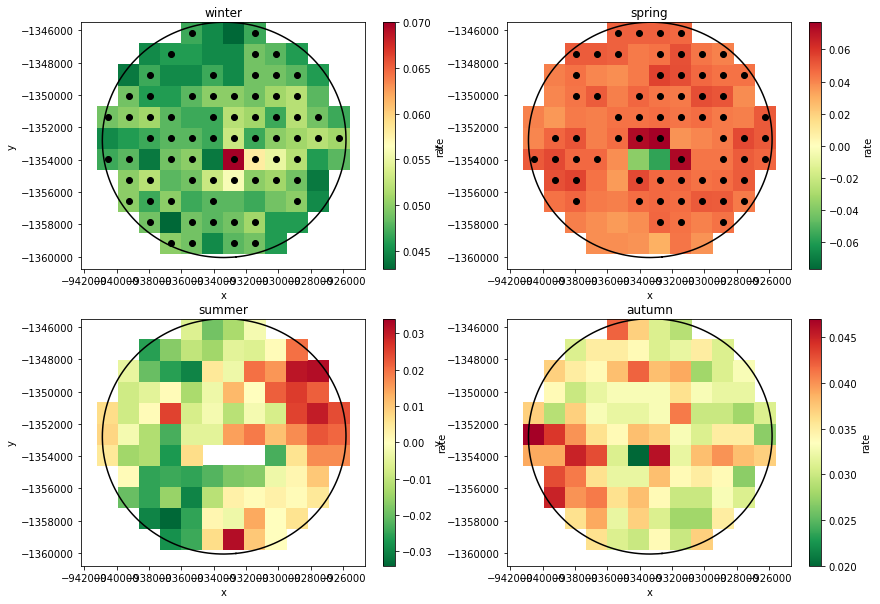

In [45]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
yearwinterRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('winter')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,2)
yearspringRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('spring')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,3)
yearsummerRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('summer')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,4)
yearautumnRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('autumn')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.show()

In [403]:
yearwinterRateData.y.min()

<xarray.DataArray 'y' ()>
array(-1359150)

**the same as above, except sharing X and Y axes**

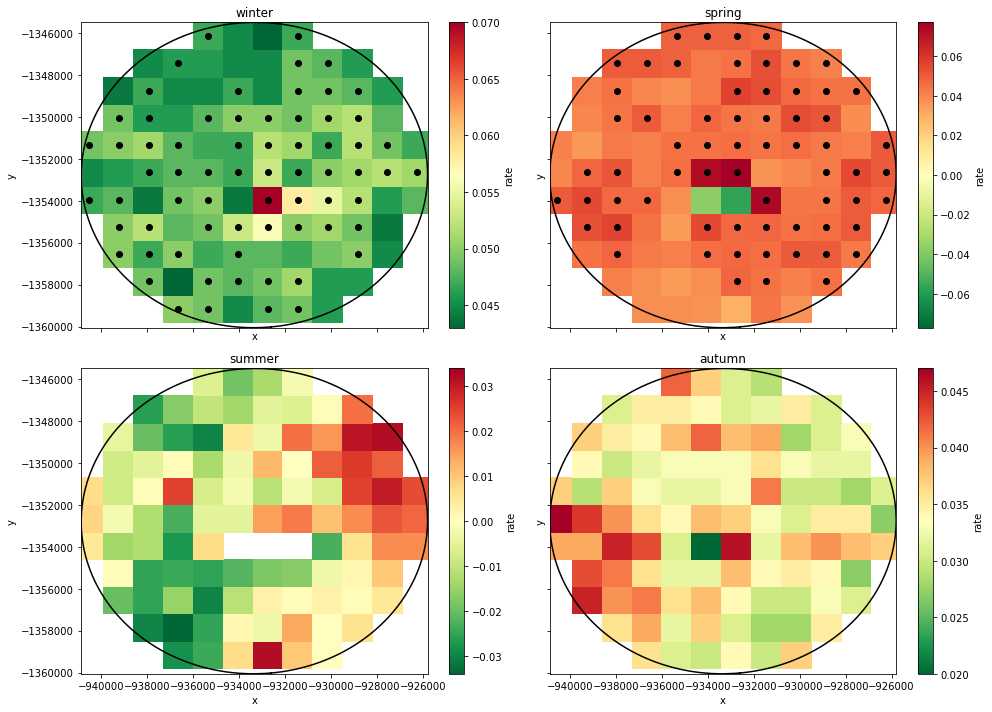

In [46]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)


f, axes = plt.subplots(2,2,sharex='all',sharey='all',figsize=(14,10))

yearwinterRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,0])
axes[0,0].set_title('winter')
#axes[0,0].axis('equal')

tempDF = yearwinterRateDF[yearwinterRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')


yearspringRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,1])
axes[0,1].set_title('spring')
#axes[0,1].axis('equal')

tempDF = yearspringRateDF[yearspringRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')
    

yearsummerRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,0])
axes[1,0].set_title('summer')
#axes[1,0].axis('equal')

tempDF = yearsummerRateDF[yearsummerRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']

axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
    

yearautumnRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,1])
axes[1,1].set_title('autumn')
#axes[1,1].axis('equal')

tempDF = yearautumnRateDF[yearautumnRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]    
    axes[1,1].plot(x, y, 'k')

xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)
#xmin = yearautumnRateData.x.min()
#xmax = yearautumnRateData.x.max()
#ymin = yearautumnRateData.y.min()
#ymax = yearautumnRateData.y.max()
#axes[0,0].axis([-942000,-924000,-1362000,-1344000])
axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()

In [209]:
sstDF.head(10)

,1,2,3,4,5,6,7,8,9,10,...,150,151,152,153,154,155,156,year,season,month
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,winter,07


**function for generating annual time-series of monthly mean for each valid pixel**

In [47]:
def yearmonthSST(month):
    tempDF = pd.DataFrame()
    for col in sstDF.columns:
        
        if col.isdigit():
            
            nuData = sstDF.index.size - np.isnan(sstDF[col]).sum()
            if nuData > 0:
                x = sstDF[sstDF['month'] == month]
                y = x[col].groupby(x['year'])
                
                xDF = y.describe() # a DataFrame containing the results of the groupby operation
                tempDF[col] = xDF['mean'] # only interest in the mean statists
                
    return tempDF

**function for calculating warming rates of annual time-series of monthly mean for each valid pixel**

In [48]:
import statsmodels.formula.api as sm
def yearmonthTrend(yearmonthDF,month):
    ind = np.arange(1,yearmonthDF.index.size+1,1)
    yearmonthDF['ind'] = ind
    yearmonthRateDF = pd.DataFrame()
    idList = []
    rateList = []
    pValueList = []
    for col in yearmonthDF.columns:
        
        if col.isdigit():
            idList.append(col)
            x = yearmonthDF.index.size - np.isnan(yearmonthDF[col]).sum()
            f = x/yearmonthDF.index.size
            if f > 0.5:
                
                # note the Q() function for the proper handling of the number as a column name
                formula = 'Q("' + col + '")' + ' ~ ind'

                fit = sm.ols(formula=formula, data=yearmonthDF, missing='drop').fit()

                predict = fit.predict(yearmonthDF)
                yearmonthDF['fitted'] = predict
                rate = round(fit.params[1],3)
                pValue = round(fit.pvalues[1],2)
            else:
                rate = np.nan
                pValue = np.nan

            rateList.append(rate)
            pValueList.append(pValue)
        else:
            break
    yearmonthRateDF['id'] = idList
    yearmonthRateDF['rate'] = rateList
    yearmonthRateDF['pValue'] = pValueList

    countList = []
    freqList = []
    tempDF = sstDF[sstDF['month'] == month]
    
    for col in yearmonthDF.columns:
        
        if col.isdigit():        
            x = tempDF.index.size - np.isnan(tempDF[col]).sum()
            
                      
            f = x/tempDF.index.size
           
            countList.append(x)
            freqList.append(f)
        else:
            break
    yearmonthRateDF['count'] = countList
    yearmonthRateDF['frequency'] = freqList
    yearmonthRateDF.set_index("id",inplace=True)
    
    return yearmonthRateDF

**calculate annual time-series of monthly means and their trends**

In [49]:
yearJanDF = yearmonthSST('01')
yearJanRateDF = yearmonthTrend(yearJanDF,'01')
yearFebDF = yearmonthSST('02')
yearFebRateDF = yearmonthTrend(yearFebDF,'02')
yearMarDF = yearmonthSST('03')
yearMarRateDF = yearmonthTrend(yearMarDF,'03')
yearAprDF = yearmonthSST('04')
yearAprRateDF = yearmonthTrend(yearAprDF,'04')
yearMayDF = yearmonthSST('05')
yearMayRateDF = yearmonthTrend(yearMayDF,'05')
yearJunDF = yearmonthSST('06')
yearJunRateDF = yearmonthTrend(yearJunDF,'06')
yearJulDF = yearmonthSST('07')
yearJulRateDF = yearmonthTrend(yearJulDF,'07')
yearAugDF = yearmonthSST('08')
yearAugRateDF = yearmonthTrend(yearAugDF,'08')
yearSepDF = yearmonthSST('09')
yearSepRateDF = yearmonthTrend(yearSepDF,'09')
yearOctDF = yearmonthSST('10')
yearOctRateDF = yearmonthTrend(yearOctDF,'10')
yearNovDF = yearmonthSST('11')
yearNovRateDF = yearmonthTrend(yearNovDF,'11')
yearDecDF = yearmonthSST('12')
yearDecRateDF = yearmonthTrend(yearDecDF,'12')

In [286]:
yearFebRateDF

,rate,pValue,count,frequency
id,,,,
17,-0.014,0.75,75,0.156250
18,-0.016,0.71,77,0.160417
19,-0.001,0.98,79,0.164583
20,0.008,0.86,76,0.158333
27,0.004,0.92,76,0.158333
...,...,...,...,...
137,0.030,0.61,73,0.152083
138,0.021,0.67,69,0.143750
139,0.018,0.68,73,0.152083


In [290]:
yearMarRateDF['pValue'].mean()

0.2891000000000001

In [50]:
xList = []
yList = []
for id in yearJanRateDF.index:
    x = int(latlonDF.loc[id]['lon'])
    y = int(latlonDF.loc[id]['lat'])
    xList.append(x)
    yList.append(y)
yearJanRateDF['x'] = xList
yearJanRateDF['y'] = yList
yearFebRateDF['x'] = xList
yearFebRateDF['y'] = yList
yearMarRateDF['x'] = xList
yearMarRateDF['y'] = yList
yearAprRateDF['x'] = xList
yearAprRateDF['y'] = yList
yearMayRateDF['x'] = xList
yearMayRateDF['y'] = yList
yearJunRateDF['x'] = xList
yearJunRateDF['y'] = yList
yearJulRateDF['x'] = xList
yearJulRateDF['y'] = yList
yearAugRateDF['x'] = xList
yearAugRateDF['y'] = yList
yearSepRateDF['x'] = xList
yearSepRateDF['y'] = yList
yearOctRateDF['x'] = xList
yearOctRateDF['y'] = yList
yearNovRateDF['x'] = xList
yearNovRateDF['y'] = yList
yearDecRateDF['x'] = xList
yearDecRateDF['y'] = yList


In [51]:
import xarray as xr
yearJanRateDF1 = yearJanRateDF.copy()
yearJanRateDF1.set_index(['y','x'],inplace=True)
yearJanRateData = xr.Dataset.from_dataframe(yearJanRateDF1)
yearJanRateData.attrs['crs']='EPSG:3577'
yearJanRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJanRateData.nc')

import xarray as xr
yearFebRateDF1 = yearFebRateDF.copy()
yearFebRateDF1.set_index(['y','x'],inplace=True)
yearFebRateData = xr.Dataset.from_dataframe(yearFebRateDF1)
yearFebRateData.attrs['crs']='EPSG:3577'
yearFebRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearFebRateData.nc')

import xarray as xr
yearMarRateDF1 = yearMarRateDF.copy()
yearMarRateDF1.set_index(['y','x'],inplace=True)
yearMarRateData = xr.Dataset.from_dataframe(yearMarRateDF1)
yearMarRateData.attrs['crs']='EPSG:3577'
yearMarRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearMarRateData.nc')

import xarray as xr
yearAprRateDF1 = yearAprRateDF.copy()
yearAprRateDF1.set_index(['y','x'],inplace=True)
yearAprRateData = xr.Dataset.from_dataframe(yearAprRateDF1)
yearAprRateData.attrs['crs']='EPSG:3577'
yearAprRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearAprRateData.nc')

import xarray as xr
yearMayRateDF1 = yearMayRateDF.copy()
yearMayRateDF1.set_index(['y','x'],inplace=True)
yearMayRateData = xr.Dataset.from_dataframe(yearMayRateDF1)
yearMayRateData.attrs['crs']='EPSG:3577'
yearMayRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearMayRateData.nc')

import xarray as xr
yearJunRateDF1 = yearJunRateDF.copy()
yearJunRateDF1.set_index(['y','x'],inplace=True)
yearJunRateData = xr.Dataset.from_dataframe(yearJunRateDF1)
yearJunRateData.attrs['crs']='EPSG:3577'
yearJunRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJunRateData.nc')

import xarray as xr
yearJulRateDF1 = yearJulRateDF.copy()
yearJulRateDF1.set_index(['y','x'],inplace=True)
yearJulRateData = xr.Dataset.from_dataframe(yearJulRateDF1)
yearJulRateData.attrs['crs']='EPSG:3577'
yearJulRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearJulRateData.nc')

import xarray as xr
yearAugRateDF1 = yearAugRateDF.copy()
yearAugRateDF1.set_index(['y','x'],inplace=True)
yearAugRateData = xr.Dataset.from_dataframe(yearAugRateDF1)
yearAugRateData.attrs['crs']='EPSG:3577'
yearAugRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearAugRateData.nc')

import xarray as xr
yearSepRateDF1 = yearSepRateDF.copy()
yearSepRateDF1.set_index(['y','x'],inplace=True)
yearSepRateData = xr.Dataset.from_dataframe(yearSepRateDF1)
yearSepRateData.attrs['crs']='EPSG:3577'
yearSepRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearSepRateData.nc')

import xarray as xr
yearOctRateDF1 = yearOctRateDF.copy()
yearOctRateDF1.set_index(['y','x'],inplace=True)
yearOctRateData = xr.Dataset.from_dataframe(yearOctRateDF1)
yearOctRateData.attrs['crs']='EPSG:3577'
yearOctRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearOctRateData.nc')

import xarray as xr
yearNovRateDF1 = yearNovRateDF.copy()
yearNovRateDF1.set_index(['y','x'],inplace=True)
yearNovRateData = xr.Dataset.from_dataframe(yearNovRateDF1)
yearNovRateData.attrs['crs']='EPSG:3577'
yearNovRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearNovRateData.nc')

import xarray as xr
yearDecRateDF1 = yearDecRateDF.copy()
yearDecRateDF1.set_index(['y','x'],inplace=True)
yearDecRateData = xr.Dataset.from_dataframe(yearDecRateDF1)
yearDecRateData.attrs['crs']='EPSG:3577'
yearDecRateData.to_netcdf(path='/home/547/zxh547/dea-notebooks/yearDecRateData.nc')

**display spatial patterns of annual warming rates of monthly means; the black dots indicate statistical signficance at 90% confidence level**

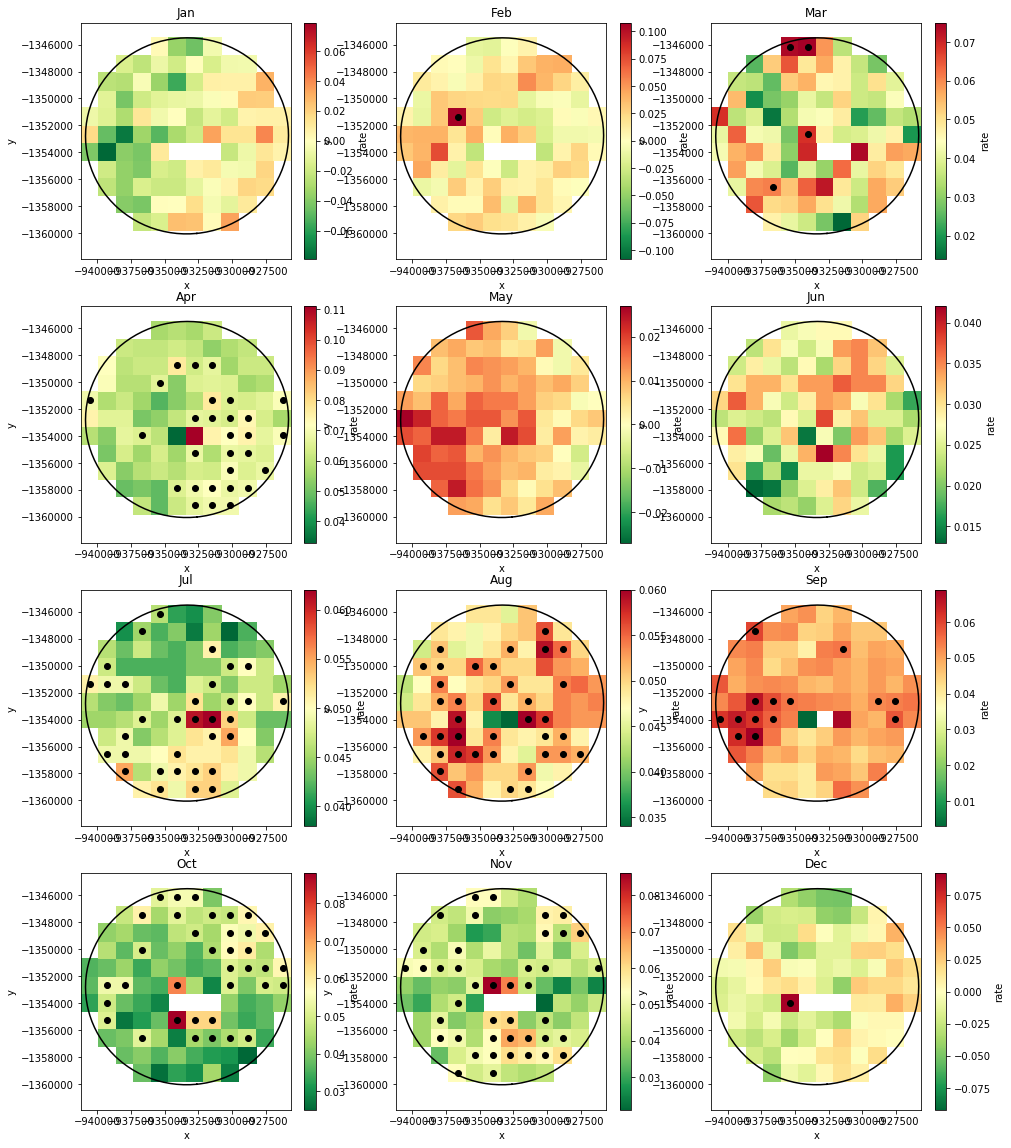

In [52]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)


plt.figure(figsize=(16,20))

plt.subplot(4,3,1)
yearJanRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jan')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,2)
yearFebRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Feb')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,3)
yearMarRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Mar')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,4)
yearAprRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Apr')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,5)
yearMayRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('May')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,6)
yearJunRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jun')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,7)
yearJulRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Jul')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,8)
yearAugRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Aug')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,9)
yearSepRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Sep')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,10)
yearOctRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Oct')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,11)
yearNovRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Nov')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


plt.subplot(4,3,12)
yearDecRateData['rate'].plot(cmap='RdYlGn_r')
plt.title('Dec')
plt.axis('equal')
#yearwinterRateDF.plot.scatter('y','x',c='pValue')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
#pValue = yearwinterRateDF['pValue']
plt.scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')


**the same as above, except sharing the X and Y axes**

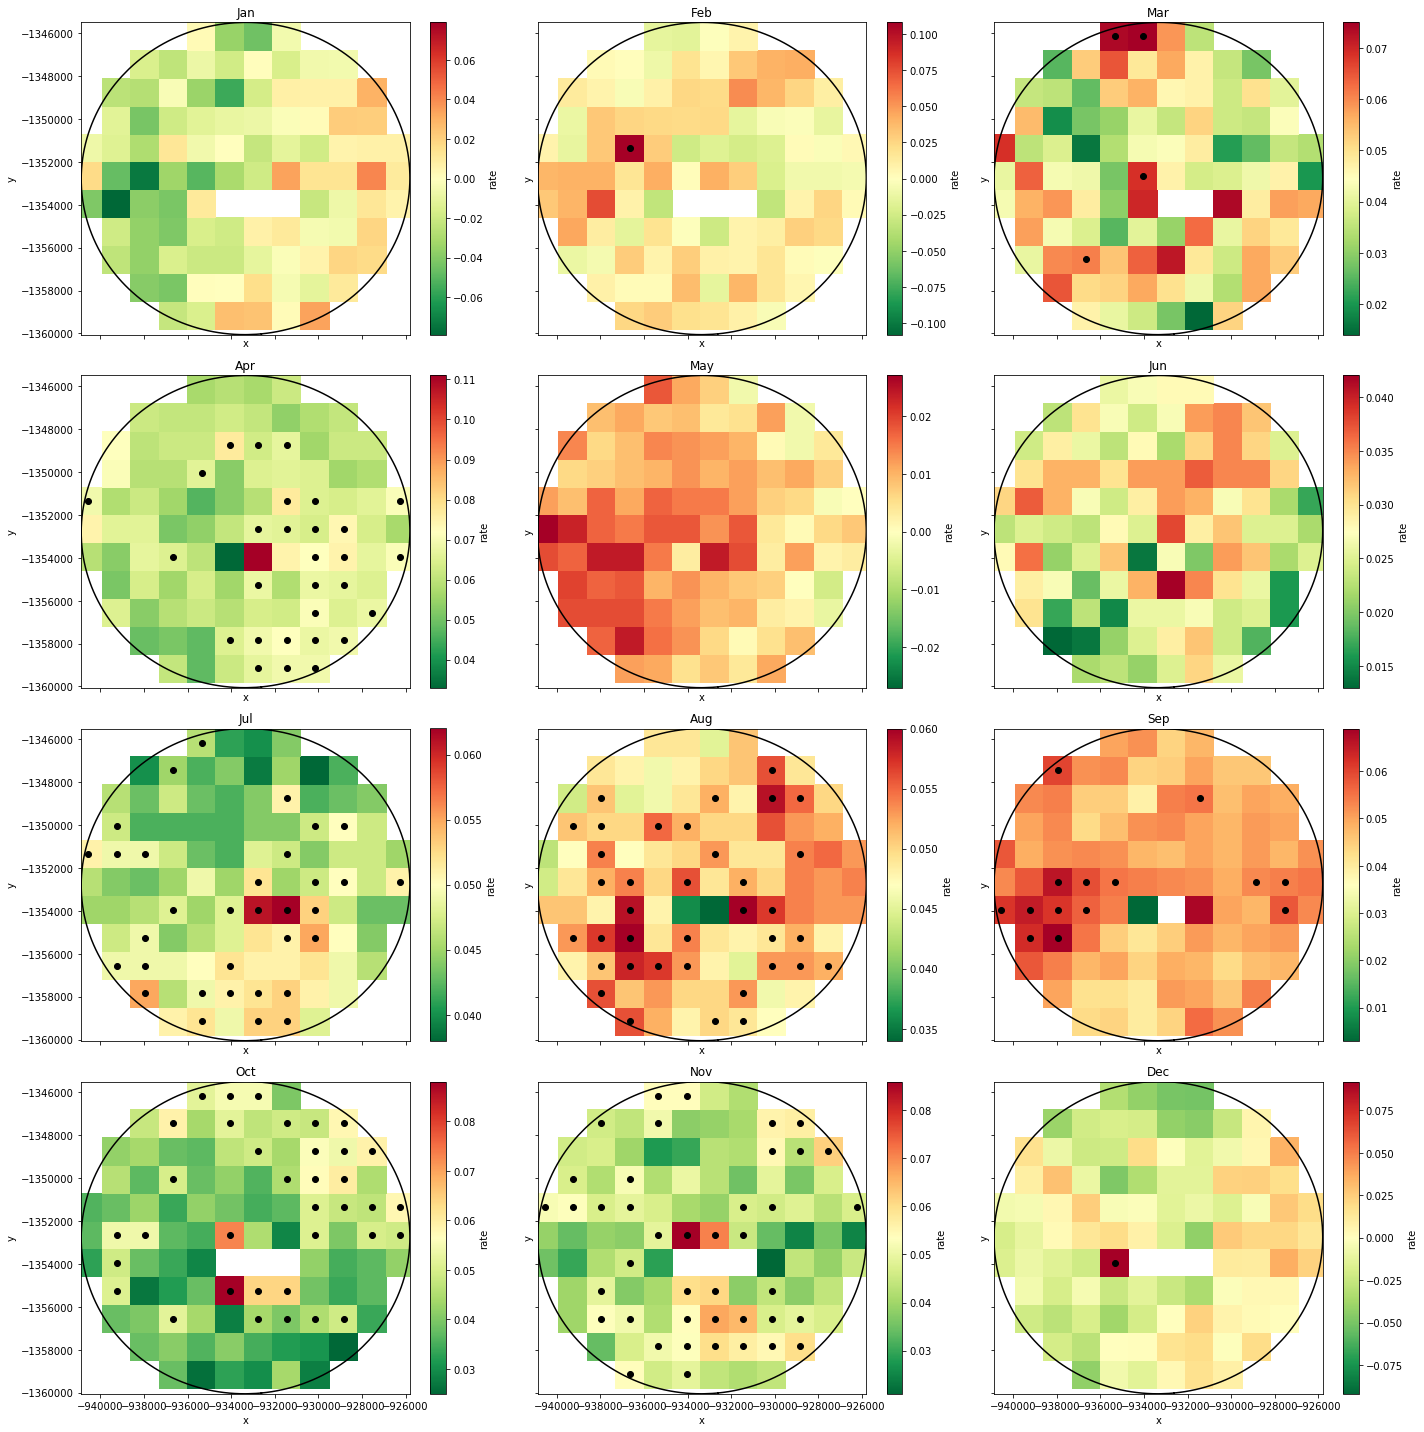

In [53]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)

f, axes = plt.subplots(4,3,sharex='all',sharey='all',figsize=(20,20))

yearJanRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,0])
axes[0,0].set_title('Jan')
tempDF = yearJanRateDF[yearJanRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,0].plot(x, y, 'k')

yearFebRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,1])
axes[0,1].set_title('Feb')
tempDF = yearFebRateDF[yearFebRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,1].plot(x, y, 'k')

yearMarRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[0,2])
axes[0,2].set_title('Mar')
tempDF = yearMarRateDF[yearMarRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[0,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[0,2].plot(x, y, 'k')
    
yearAprRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,0])
axes[1,0].set_title('Apr')
tempDF = yearAprRateDF[yearAprRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,0].plot(x, y, 'k')
    
yearMayRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,1])
axes[1,1].set_title('May')
tempDF = yearMayRateDF[yearMayRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,1].plot(x, y, 'k')
    
yearJunRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[1,2])
axes[1,2].set_title('Jun')
tempDF = yearJunRateDF[yearJunRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[1,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[1,2].plot(x, y, 'k')
    
yearJulRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,0])
axes[2,0].set_title('Jul')
tempDF = yearJulRateDF[yearJulRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,0].plot(x, y, 'k')
    
yearAugRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,1])
axes[2,1].set_title('Aug')
tempDF = yearAugRateDF[yearAugRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,1].plot(x, y, 'k')
    
yearSepRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[2,2])
axes[2,2].set_title('Sep')
tempDF = yearSepRateDF[yearSepRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[2,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[2,2].plot(x, y, 'k')
    
yearOctRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,0])
axes[3,0].set_title('Oct')
tempDF = yearOctRateDF[yearOctRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,0].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,0].plot(x, y, 'k')
    
yearNovRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,1])
axes[3,1].set_title('Nov')
tempDF = yearNovRateDF[yearNovRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,1].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,1].plot(x, y, 'k')
    
yearDecRateData['rate'].plot(cmap='RdYlGn_r',ax=axes[3,2])
axes[3,2].set_title('Dec')
tempDF = yearDecRateDF[yearDecRateDF['pValue'] <= 0.1]
x = tempDF['x']
y = tempDF['y']
axes[3,2].scatter(x,y,c='black')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    axes[3,2].plot(x, y, 'k')
    
xmin = min(x)
xmax = max(x)
ymin = min(y)
ymax = max(y)

axes[0,0].axis([xmin,xmax,ymin,ymax])
f.tight_layout()    
plt.show()